In [1]:
from transformers import VisionEncoderDecoderConfig
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()

PROJECT_DIR = os.getenv("PROJECT_DIR")
DEAL_ANNOTATION_PATH = os.path.join(PROJECT_DIR, "labeled_deals_gabriel.csv")
LEAFLET_DIR = os.path.join(PROJECT_DIR, "crawled_leaflets")
DABASE_PATH = os.path.join(LEAFLET_DIR, "supermarket_leaflets.db")
DEALS_DIR = os.path.join(PROJECT_DIR, "deals")

image_size = [640, 480]
max_length = 768
cache_dir = r"W:\Others\Cache\Cache__Huggingface"

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained(
    "naver-clova-ix/donut-base-finetuned-cord-v2", cache_dir=cache_dir
)
config.encoder.image_size = image_size  # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

In [2]:
deal_annotation_df = pd.read_csv(DEAL_ANNOTATION_PATH, sep=", ")
deal_annotation_df2 = pd.read_csv(
    DEAL_ANNOTATION_PATH.replace("gabriel", "ilyi"), sep=","
)
# merge the two annotations
deal_annotation_df = pd.concat([deal_annotation_df, deal_annotation_df2]).reset_index(drop=True)
# save to csv
deal_annotation_df.to_csv(os.path.join(PROJECT_DIR, "labeled_deals_all.csv"), index=False)


# add .png to img_name if not present
deal_annotation_df["img_name"] = deal_annotation_df["img_name"].apply(
    lambda x: x if x.endswith(".png") else x + ".png"
)
annotated_images = deal_annotation_df["img_name"].tolist()
all_deal_images = {}
# with os.walk
for root, dirs, files in os.walk(DEALS_DIR):
    for file in files:
        if file in annotated_images:
            all_deal_images[file] = os.path.join(root, file)

deal_annotation_df["img_path"] = deal_annotation_df["img_name"].map(
    lambda x: all_deal_images[x]
)

C:\Users\gabri\AppData\Local\Temp\ipykernel_3888\671904792.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  deal_annotation_df = pd.read_csv(DEAL_ANNOTATION_PATH, sep=", ")


In [3]:
# # split the df randomly into train and validation
# deal_annotation_df = deal_annotation_df.sample(frac=1, random_state=42).reset_index(
#     drop=True
# )
# train_size = int(0.8 * len(deal_annotation_df))
# train_df = deal_annotation_df.iloc[:train_size]
# val_df = deal_annotation_df.iloc[train_size:]
# train_df = train_df.reset_index(drop=True)
# val_df = val_df.reset_index(drop=True)

# train_df.to_csv(os.path.join(PROJECT_DIR, "train_deals.csv"), index=False)
# val_df.to_csv(os.path.join(PROJECT_DIR, "val_deals.csv"), index=False)

train_df = pd.read_csv(os.path.join(PROJECT_DIR, "train_deals.csv"))
val_df = pd.read_csv(os.path.join(PROJECT_DIR, "val_deals.csv"))

In [4]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained(
    "naver-clova-ix/donut-base-finetuned-cord-v2", cache_dir=cache_dir
)

# add ä, ö, ü, ß to the special tokens
processor.tokenizer.add_tokens(
    [
        "ä",
        "ö",
        "ü",
        "ß",
        "€",
        "é",
        "ó",
        "á",
        "í",
        "ú",
        "Ä",
        "Ö",
        "Ü",
        "É",
        "Ó",
        "Á",
        "Í",
        "Ú",
        "-",
        ".",
        ",",
        ":",
        ";",
        "!",
    ]
)

model = VisionEncoderDecoderModel.from_pretrained(
    "naver-clova-ix/donut-base-finetuned-cord-v2", config=config, cache_dir=cache_dir
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    640,
    480
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "transformers_ve

In [5]:
import json
import random
from typing import Any, List, Tuple
from PIL import Image

import torch
from torch.utils.data import Dataset

added_tokens = []


class DonutDataset(Dataset):
    """
    PyTorch Dataset for Donut. This class takes a HuggingFace Dataset as input.

    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into pixel_values (vectorized image) and labels (input_ids of the tokenized string).

    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        df: pd.DataFrame,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id

        self.df = df.reset_index(drop=True)
        self.df["gt_data"] = self.df.apply(self.create_gt_sequence, axis=1)
        self.add_tokens(["<s_cord-v2>", "<s_cord-v2>"])
        self.dataset_length = len(self.df)
        self.ret_full_sample = False

    def create_gt_sequence(self, row):
        data = {
            "brand": row["Marke"],
            "productname": row["Produktname"],
            "original_price": row["Original Preis"],
            "deal_price": row["Reduzierter Preis"],
            "weight": row["Gewicht"],
        }
        gt = ""
        for k, v in data.items():
            if not pd.isna(v):
                start_token, end_token = f"<s_{k}>", f"</s_{k}>"
                self.add_tokens([start_token, end_token])
                gt += f"{start_token}{v}{end_token}"
        gt += "</s>"
        return gt.strip()

    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.df.iloc[idx]
        image = Image.open(sample["img_path"]).convert("RGB")

        # inputs
        pixel_values = processor(
            image, random_padding=self.split == "train", return_tensors="pt"
        ).pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        target_sequence = sample["gt_data"]
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = (
            self.ignore_id
        )  # model doesn't need to predict pad token
        if not self.ret_full_sample:
            return pixel_values, labels, target_sequence
        return pixel_values, labels, target_sequence, sample.to_dict()


processor.image_processor.size = image_size[::-1]  # should be (width, height)
processor.image_processor.do_align_long_axis = False

train_dataset = DonutDataset(train_df, max_length=max_length, split="train")

val_dataset = DonutDataset(val_df, max_length=max_length, split="validation")


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [6]:
print("Original number of tokens:", processor.tokenizer.vocab_size)
print("Number of tokens after adding special tokens:", len(processor.tokenizer))
pixel_values, labels, target_sequence = train_dataset[0]
print(pixel_values.shape)
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(
    ["<s_cord-v2>"]
)[0]
model.config.eos_token_id = processor.tokenizer.eos_token_id
processor.decode([57532])

Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, if both images and text are provided, the default value of `add_special_tokens` will be changed to `False` when calling the tokenizer if `add_special_tokens` is unset. To test the new behavior, set `legacy=False`as a processor call argument.
Keyword argument `random_padding` is not a valid argument for this processor and will be ignored.


Original number of tokens: 57522
Number of tokens after adding special tokens: 57590
torch.Size([3, 640, 480])


'<s_price>'

In [7]:
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print(
    "Decoder start token ID:", processor.decode([model.config.decoder_start_token_id])
)
print("EOS token ID:", processor.decode([model.config.eos_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_cord-v2>
EOS token ID: </s>


In [8]:
from torch.utils.data import DataLoader

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

batch = next(iter(train_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

torch.Size([1, 3, 640, 480])


In [9]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
import torch.optim.adamw
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch

        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader


In [10]:
config = {
    "max_epochs": 10,
    "check_val_every_n_epoch": 1,
    "gradient_clip_val": 2.0,
    "num_training_samples_per_epoch": 800,
    "lr": 8e-6,
    "train_batch_sizes": [16],
    "val_batch_sizes": [16],
    # "seed":2022,
    "num_nodes": 1,
    "warmup_steps": 400,  # 800/8*30/10, 10%
    "result_path": "./result",
    "verbose": True,
}

model_module = DonutModelPLModule(config, processor, model)


In [11]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, EarlyStopping

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="16-mixed", # we'll use mixed precision
        num_sanity_val_steps=0,
)

trainer.fit(model_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
w:\Workspaces\Python\Studium\Master\leaflets\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generate

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

w:\Workspaces\Python\Studium\Master\leaflets\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [12]:
# plot trainer results (train and val loss)

In [13]:
def out_to_dict(seq):
    _dict = {}
    # extract all attributes from the sequence (<s_{attribute}>value</s_{attribute}>) and store them in a dictionary as attribute: value pairs
    for match in re.finditer(r"<s_(.*?)>(.*?)</s_(.*?)>", seq):
        _dict[match.group(1)] = match.group(2)
    return _dict

w:\Workspaces\Python\Studium\Master\leaflets\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Prediction: {'productname': ' Tafelivien. Abate FeteTö ren', 'deal_price': ' 1. 49', 'weight': ' 500 g'}
      Target: {'productname': 'Tafelbirnen "Abate Fetel"', 'deal_price': '1.49', 'weight': '500 g'}


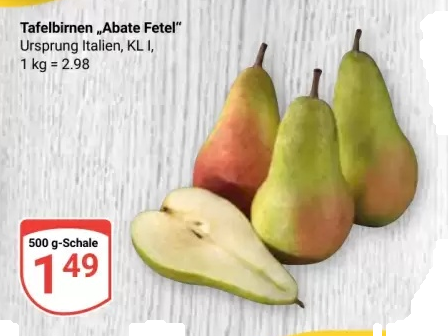

In [14]:
# load a sample from validation set
val_dataset.ret_full_sample = True
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0)
sample = next(iter(val_dataloader))
pixel_values, labels, target_sequences, sample = sample
batch_size = pixel_values.shape[0]
# we feed the prompt to the model
decoder_input_ids = torch.full(
    (batch_size, 1), model.config.decoder_start_token_id
)

outputs = model.generate(
    pixel_values,
    decoder_input_ids=decoder_input_ids,
    max_length=max_length,
    early_stopping=True,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    num_beams=1,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

predictions = []
for seq in processor.tokenizer.batch_decode(outputs.sequences):
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(
        processor.tokenizer.pad_token, ""
    ).replace("<s_cord-v2>", "").replace("</s_cord-v2>", "")
    predictions.append(seq)

img_path = sample["img_path"][0]
print(f"Prediction: {out_to_dict(predictions[0])}")
print(f"      Target: {out_to_dict(target_sequences[0])}")
Image.open(img_path)

Prediction: {'brand': ' ORAL- B', 'productname': ' Zahnbursten', 'original_price': ' 1. 45', 'deal_price': ' 1. 45', 'weight': ' 2x75ml'}


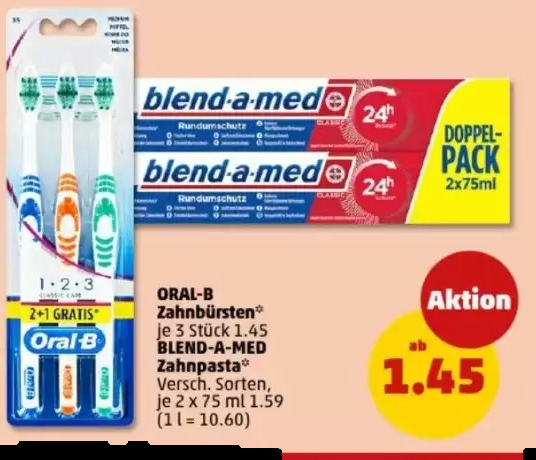

In [15]:
path_to_deal_image = r"F:\OneDrive\toShare\Gabrilyi\leaflet_project\deals\penny\2572312\30\penny_2572312_30_21713.png"
img = Image.open(path_to_deal_image).convert("RGB")

pixel_values = processor(img, return_tensors="pt").pixel_values
decoder_input_ids = torch.full(
    (1, 1), model.config.decoder_start_token_id
)

outputs = model.generate(
    pixel_values,
    decoder_input_ids=decoder_input_ids,
    max_length=max_length,
    early_stopping=True,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    num_beams=3,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

predictions = []
for seq in processor.tokenizer.batch_decode(outputs.sequences):
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(
        processor.tokenizer.pad_token, ""
    ).replace("<s_cord-v2>", "").replace("</s_cord-v2>", "")
    predictions.append(seq)

img_path = sample["img_path"][0]
print(f"Prediction: {out_to_dict(predictions[0])}")
img

In [16]:
# save model and processor
model.save_pretrained("donut_deal_model")
processor.save_pretrained("donut_deal_processor")

[]